In [1]:
%load_ext autoreload

In [136]:
%autoreload
import astropy.units as u
import cmasher as cmr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pears
import seaborn as sns
from astropy.coordinates import (
    CartesianRepresentation,
    SkyCoord,
    SphericalRepresentation,
    matrix_utilities,
)
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from IPython.display import HTML
from matplotlib import animation
from tqdm.auto import tqdm

plt.rc("text", usetex=True)


plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["figure.figsize"] = (11, 7)

In [619]:
df = pd.read_csv("/st/datasets/gaia-dr3-lite-5p-xp-rvs.csv")

In [620]:
def gspspec_flag_filter(flag_gspspec):
    return set(flag_gspspec[:13]) == {"0", "1"}


fltr = np.logical_and.reduce(
    (
        # ~df["distance_gspphot"].isna(),
        ~df["distance_msc"].isna(),
        # df["flags_flame"] == 0,
        ~df["flags_gspspec"].isna(),
        # df["flags_msc"] == 0,
        # df["distance_msc"] < 1000.0,
    )
)
df = df[fltr]
df = df[df["flags_gspspec"].apply(gspspec_flag_filter)]

len(df)

53359

In [621]:
coords = SkyCoord(
    ra=u.Quantity(df["ra"], u.deg),
    dec=u.Quantity(df["dec"], u.deg),
    distance=u.Quantity(df["distance_msc"], u.pc),
    # distance=u.Quantity(df['parallax'], u.mas).to(u.pc, u.parallax()),
    pm_ra_cosdec=u.Quantity(df["pmra"] * np.cos(np.deg2rad(df["dec"])), u.mas / u.yr),
    pm_dec=u.Quantity(df["pmdec"], u.mas / u.yr),
    radial_velocity=u.Quantity(df["radial_velocity"], u.km / u.s),
    frame="icrs",
)
gc = coords.galactocentric
radius = np.sqrt(np.sum(np.square(gc.cartesian.xyz[:2]), axis=0))

In [609]:
def wrap_at(x, wrap):
    x_copy = np.copy(x)
    mask = x_copy > wrap
    x_copy[mask] = x_copy[mask] - 2.0 * wrap
    return x_copy

([], [])

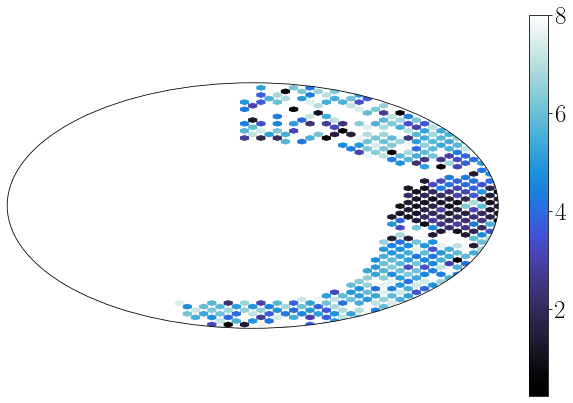

In [610]:
plt.subplot(111, projection="aitoff")
plt.hexbin(
    np.deg2rad(wrap_at(df["l"], 180.0)),
    np.deg2rad(df["b"]),
    C=df["age_flame"],
    cmap=cmr.freeze,
    vmax=8,
    gridsize=60,
)
plt.colorbar()
plt.xticks([])
plt.yticks([])

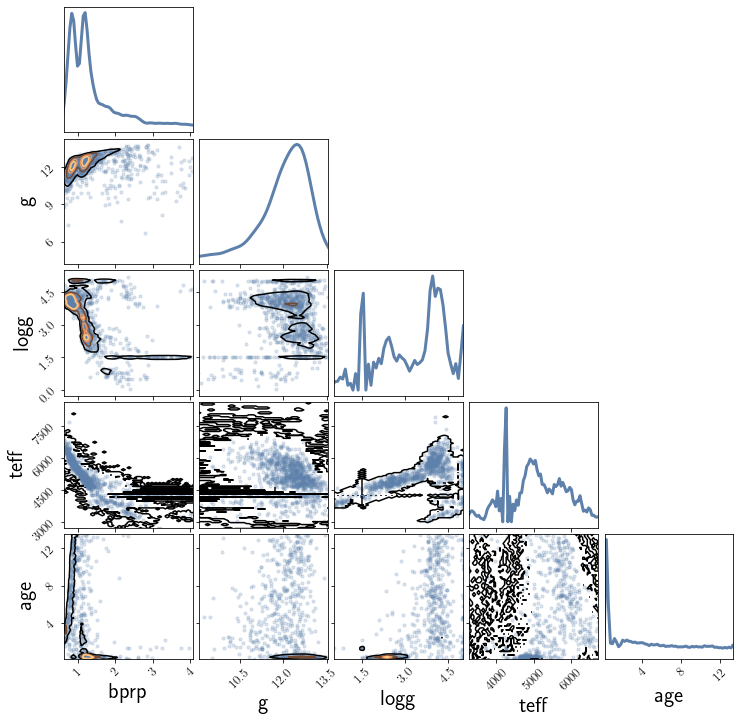

In [611]:
pears.pears(
    dict(
        bprp=df["phot_bp_mean_mag"] - df["phot_rp_mean_mag"],
        g=df["phot_g_mean_mag"],
        logg=df["logg_gspspec"],
        teff=df["teff_gspspec"],
        age=df["age_flame"],
    ),
    scatter_thin=50,
    xlim_quantiles=(0.01, 0.99),
);

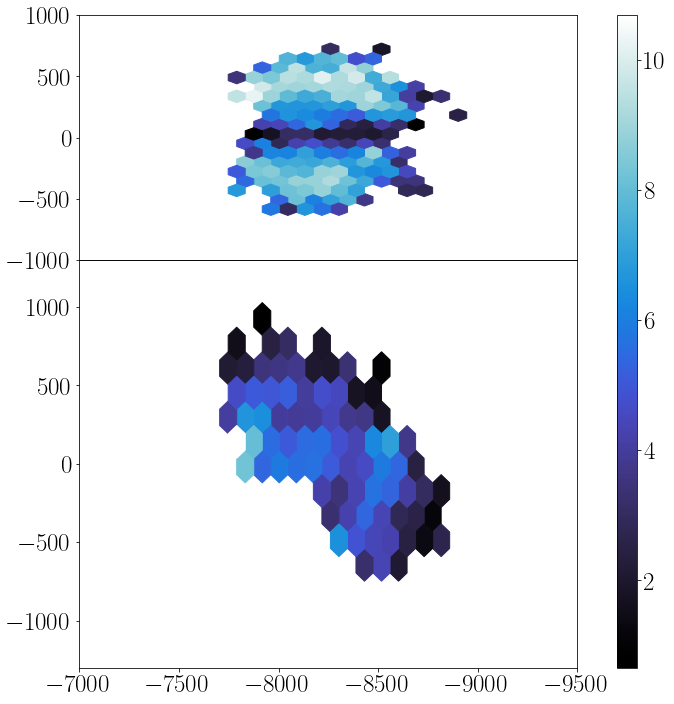

In [622]:
fig = plt.figure(figsize=(10, 12))
gs = fig.add_gridspec(
    2, 3, width_ratios=[5, 0.4, 0.2], height_ratios=[3, 5], wspace=0.0, hspace=0
)

args = dict(C=df["age_flame"], gridsize=60, cmap=cmr.freeze, mincnt=3)

ax0 = fig.add_subplot(gs[1, 0])
sc = ax0.hexbin(gc.x, gc.y, **args)
ax0.set_xlim(-7000, -9500)
ax0.set_ylim(-1300, 1300)

ax_top = fig.add_subplot(gs[0, 0], sharex=ax0)
ax_top.hexbin(gc.x, gc.z, **args)
ax_top.xaxis.set_visible(False)
ax_top.set_ylim(-1000, 1000)


cbarax = fig.add_subplot(gs[:, -1])

fig.colorbar(sc, cax=cbarax)

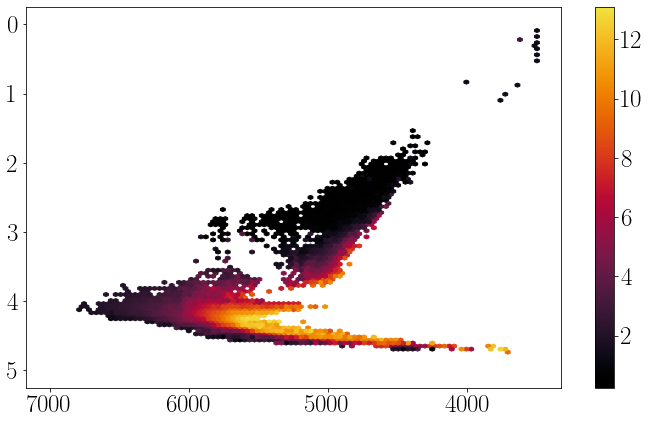

In [634]:
fig = plt.figure(figsize=(12, 7))
ax = fig.add_subplot()
sc = ax.hexbin(
    df["teff_gspphot"],
    df["logg_gspphot"],
    C=df["age_flame"],
    gridsize=100,
    cmap=cmr.ember,
    mincnt=3,
    extent=[3500, 7000, 0.0, 5.0],
)
ax.invert_xaxis()
ax.invert_yaxis()
fig.colorbar(sc)

In [624]:
def kde2d(x, y):
    mask = np.isnan(x) | np.isnan(y)
    return fastKDE.pdf(x[~mask], y[~mask])[::-1]

Text(0, 0.5, '[$\\alpha$/Fe]')

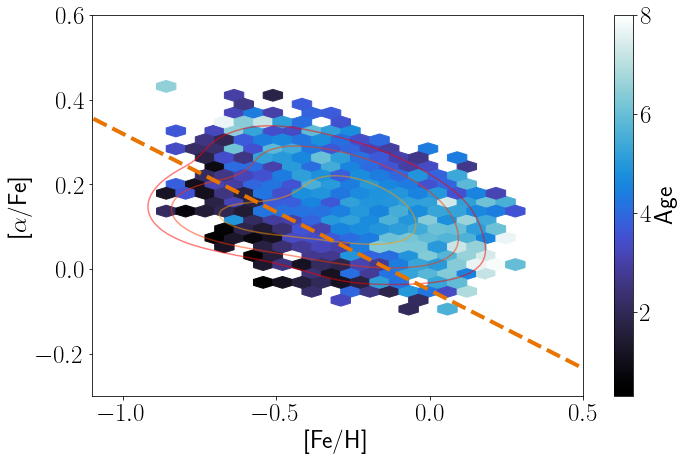

In [625]:
feh = df["fem_gspspec"] + df["mh_gspspec"]

fig, ax = plt.subplots()
# fig.set_facecolor('black')
# ax.set_facecolor('black')
sc = ax.hexbin(
    feh,
    df["alphafe_gspspec"],
    C=df["age_flame"],
    vmax=8,
    cmap=cmr.freeze,
    gridsize=50,
    mincnt=3,
)
xy, z = kde2d(feh, df["alphafe_gspspec"])
ax.contour(*xy, z, levels=[1.0, 2.0, 4.0, 6.0], cmap="autumn", alpha=0.5)

ax.set_xlim(-1.1, 0.5)
ax.set_ylim(-0.3, 0.6)
xr = np.linspace(-1.5, 0.8)
fig.colorbar(sc, label="Age")
ax.plot(xr, -0.37 * xr - 0.05, c="#e77500", lw=4, ls="--")
ax.set_xlabel("[Fe/H]")
ax.set_ylabel(r"[$\alpha$/Fe]")

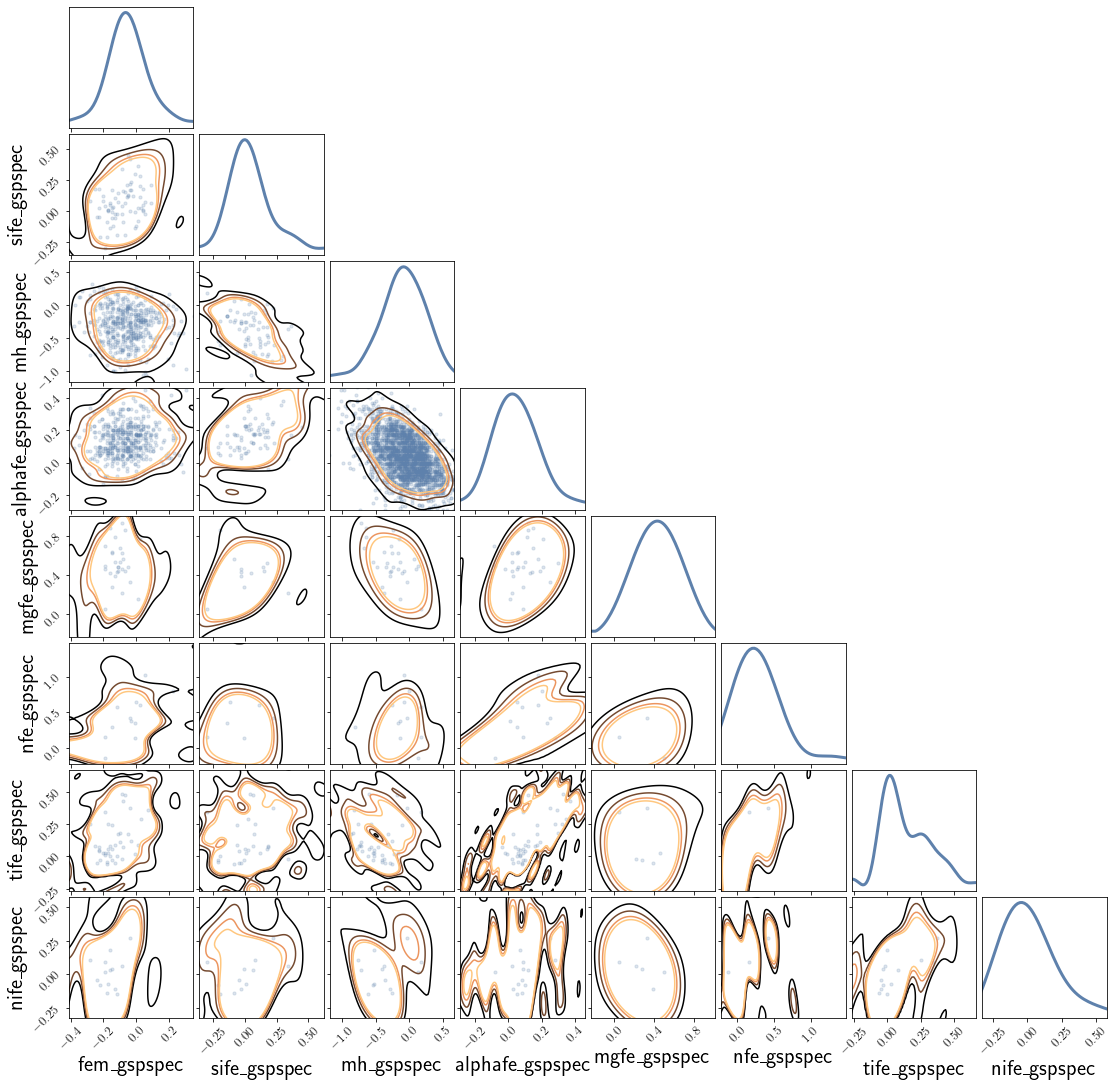

In [626]:
pears.pears(
    df,
    indices=[
        "fem_gspspec",
        "sife_gspspec",
        "mh_gspspec",
        "alphafe_gspspec",
        "mgfe_gspspec",
        "nfe_gspspec",
        "tife_gspspec",
        "nife_gspspec",
    ],
    scatter_thin=20,
    xlim_quantiles=(0.005, 0.995),
    ylim_quantiles=(0.005, 0.995),
);

In [627]:
o = Orbit(coords)
ts = np.linspace(0.0, 1.0, 500) * u.Gyr
o.integrate(ts, MWPotential2014, numcores=12)

  0%|          | 0/53359 [00:00<?, ?it/s]

In [628]:
jz = o.jz(MWPotential2014)
jr = o.jr(MWPotential2014)
lz = o.Lz()
jtot = np.sum(np.abs((lz, jr, jz)), axis=0)
# jtot = np.sqrt(np.sum(np.square((lz, jr, jz)), axis=0))

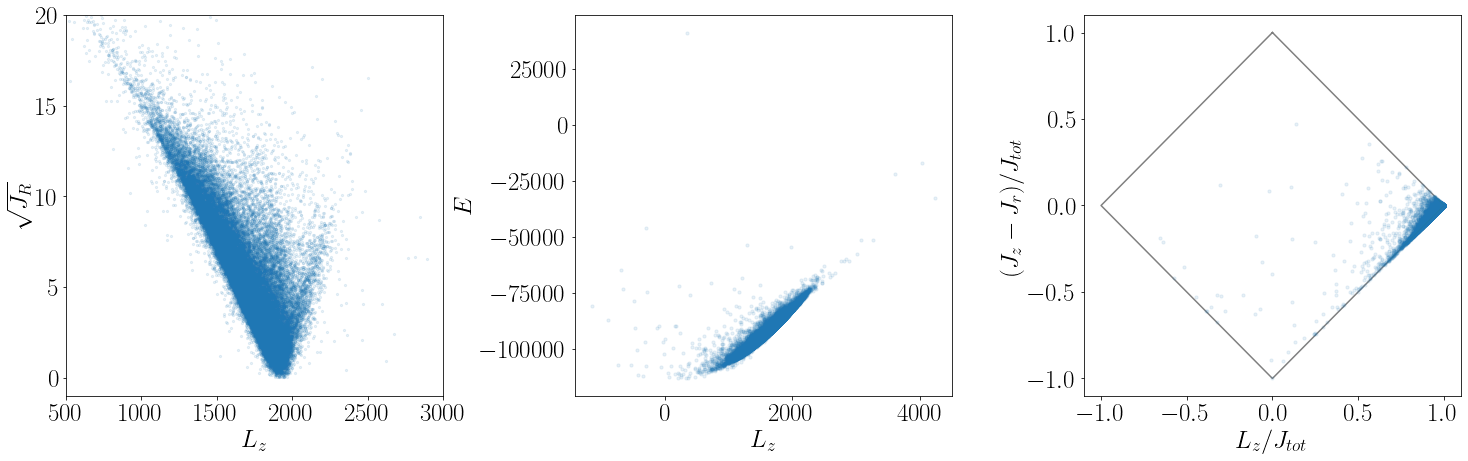

In [631]:
fig = plt.figure(figsize=(25, 7))

ax0 = fig.add_subplot(131)
ax0.scatter(lz, np.sqrt(jr), s=5, alpha=0.1)
ax0.set_ylim(-1, 20)
ax0.set_xlim(500, 3000)
ax0.set_xlabel(r"$L_z$")
ax0.set_ylabel(r"$\sqrt{J_R}$")

ax1 = fig.add_subplot(132)
ax1.scatter(lz, o.E(), s=10, alpha=0.1)
ax1.set_xlabel(r"$L_z$")
ax1.set_ylabel(r"$E$")

ax2 = fig.add_subplot(133)
ax2.scatter(lz / jtot, (jz - jr) / jtot, s=10, alpha=0.1)
ax2.set_xlabel(r"$L_z / J_{tot}$")
ax2.set_ylabel(r"$(J_z - J_r) / J_{tot}$")
plt.plot([0, 1, 0, -1, 0], [1, 0, -1.0, 0.0, 1], zorder=-1, c="k", alpha=0.5)

plt.subplots_adjust(wspace=0.35)

In [630]:
o[:20].animate(d1=["x", "r", "vr"], d2=["y", "z", "vT"], width=1000)